## Generating the Synthetic Dataset

Below are the scripts for interactively generating synthetic data for sample visualizations.

### Utils

In [ ]:
import torch
from PIL import Image
from src.image_restoration.corruption.ocean import *
import numpy as np

In [4]:
def load_image(name: str, M=256, N=256):
    image = Image.open(name).convert('RGB')
    image = image.resize((M, N))
    image = torch.tensor(np.array(image)) / 255.0
    return image

In [ ]:
class ApplyOceanCorruption:
    def __init__(self, size=(1024, 1024), device='cuda'):
        self.size = size
        self.device = device

    def _sample_parameters(self):
        """Randomly sample parameters for the ocean corruption transform."""
        # Uniformly sample the patch sizes of the waves (determines the energy and width distribution)
        Lx = random.uniform(4, 12)
        Lz = Lx
        
        # The timestep is always set to zero for single-frame generation
        t=0

        # The wind determines the the orientation and amplitude of the surface waves
        wind = torch.tensor([random.uniform(0, 10), random.uniform(0, 10)]).float()
        wind_alignment = 6 # random.uniform(0, 10)
        wave_dampening = random.uniform(0.01, 0.15)

        # Sample depth in meters, where 0.01 m represents caustics and 2.50 m occludes all information
        depth = random.uniform(0.01, 2.5)

        # The wave amplitude is sampled between realistic extremes, and determines sun glint and distortions
        wave_amplitude = random.uniform(2, 15)

        # Change the colorization (normalized RGB values) of the ocean surface
        water_albedo_bot = torch.tensor([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)])

        # Randomlysample direction of the external light source, and the internal/external scattering properties
        light = torch.tensor([random.randint(-1, 1), random.randint(-1, 1), random.randint(-1, 1)]).float()
        intensity = 2.0
        light_ambient = random.uniform(0.05, 0.1)
        light_scatter = random.uniform(0.05, 0.5)
        light_specular_gain = random.uniform(2.0, 8.0)
        light_specular_gpow = 5.0

        # Return parameters so that they can be saved as metadata
        return {
            "Lx": Lx, "Lz": Lz, "t": t, "wind": wind.tolist(),
            "wind_alignment": wind_alignment, "wave_dampening": wave_dampening,
            "wave_amplitude": wave_amplitude, "depth": depth,
            "water_albedo_bot": water_albedo_bot.tolist(), "light": light.tolist(),
            "intensity": intensity, "light_ambient": light_ambient,
            "light_scatter": light_scatter, "light_specular_gain": light_specular_gain,
            "light_specular_gpow": light_specular_gpow
        }

    def __call__(self, image: torch.Tensor) -> (torch.Tensor, dict):
        """Applies ocean corruption to an image."""
        params = self._sample_parameters()
        
        # Generate ocean patch
        patch = generate_ocean_patch(
            params["Lx"], params["Lz"], self.size[0], self.size[1], 
            torch.tensor(params["wind"]), params["t"], 
            wind_alignment=params["wind_alignment"], 
            wave_dampening=params["wave_dampening"], 
            wave_amplitude=params["wave_amplitude"]
        )

        # Normalize light
        light = torch.tensor(params["light"]) / torch.norm(torch.tensor(params["light"])) * params["intensity"]

        # Create depth map
        depth_map = torch.full(self.size, params["depth"])

        # Apply ocean corruption
        image_corrupted = apply_corruption_ocean(
            patch, image, depth_map, light, torch.tensor(params["water_albedo_bot"]),
            light_ambient=params["light_ambient"],
            light_scatter=params["light_scatter"],
            light_specular_gain=params["light_specular_gain"],
            light_specular_gpow=params["light_specular_gpow"],
            device=self.device
        )

        return image_corrupted, params

### Generate a sample visualization

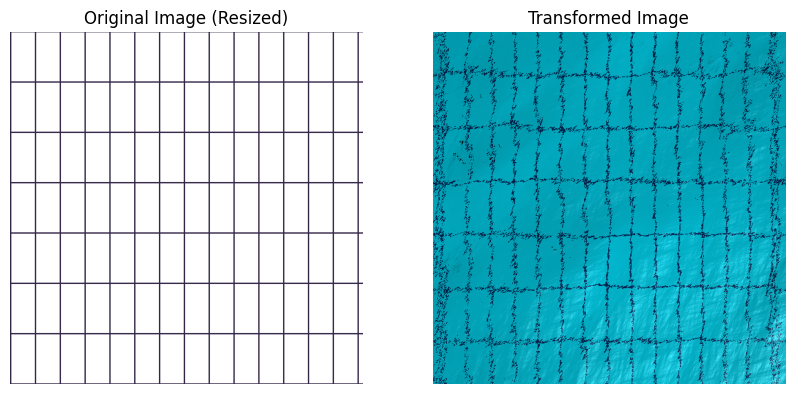

In [10]:
# Define the ApplyOceanCorruption transform
ocean_transform = ApplyOceanCorruption(Lx=32, Lz=32, size=(512, 512), device='cuda')

# add_noise_transform = lambda x: x + torch.randn_like(x) * 0.5  # Add Gaussian noise with std=0.1

# Path to the assets folder
assets_folder = "checkerboard_dataset"

# Process all images in the folder
for filename in os.listdir(assets_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Ensure valid image files
        image_path = os.path.join(assets_folder, filename)
        
        # Load the image
        image = load_image(image_path, M=512, N=512)
        # transformed_tensor = add_noise_transform(image)
        # Apply the ocean corruption transform
        transformed_tensor = ocean_transform(image)
        # print(transformed_tensor.shape)
        
        # Convert the transformed tensor back to a PIL image
        transformed_image = transformed_tensor.cpu().numpy()
        
        # Display the original and transformed images
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title("Original Image (Resized)")
        axs[0].axis("off")
        
        axs[1].imshow(transformed_image)
        axs[1].set_title("Transformed Image")
        axs[1].axis("off")
        
        plt.show()
        break


## Generate Dataset

### Distort ImageNet and BOSS Datasets

Distort the 1M+ and 100K images from the ImageNet and BOSS (https://visionlab.is/stimuli-objects/) datasets.

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
from src.image_restoration.corruption.transforms import ApplyOceanCorruption
import matplotlib.pyplot as plt

# Define the ApplyOceanCorruption transform
ocean_transform = ApplyOceanCorruption(Lx=32, Lz=32, size=(512, 512), device='cuda')
# add_noise_transform = lambda x: x + torch.randn_like(x) * 0.2  # Add Gaussian noise with std=0.1

# Input and output directories
ground_truth_folder = "ground_truthv2"
distorted_folder = "distorted"

# Ensure output folder exists
os.makedirs(distorted_folder, exist_ok=True)
os.makedirs(ground_truth_folder, exist_ok=True)

# Get all image paths from the ground truth folder
image_paths = [
    os.path.join(ground_truth_folder, filename)
    for filename in os.listdir(ground_truth_folder)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg'))
]

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Process and save images
for image_path in image_paths:
    # Get the filename
    filename = os.path.basename("ground_truth/"+image_path)

    image = load_image(image_path, M=512, N=512)
    # transformed_tensor = add_noise_transform(image)

    # Apply the ocean corruption transform
    transformed_tensor = ocean_transform(image)

    # Convert tensors back to PIL images
    distorted_image = transforms.ToPILImage()(transformed_tensor.cpu().numpy())

    distorted_image.save(os.path.join(distorted_folder, filename))

print(f"Distorted images saved in '{distorted_folder}'.")


### Checkerboard Dataset

This includes 10,000 images of randomized checkerboards, with varying grid sizes, orientations, colors, and line thicknesses.

In [1]:
import os
import random
from PIL import Image, ImageDraw
import numpy as np

# Output directory
output_dir = "checkerboard_dataset"
os.makedirs(output_dir, exist_ok=True)

# Parameters
num_images = 10
image_size = (512, 512)  # Size of the checkerboard images (width, height)
min_cells = 4  # Minimum number of cells in one dimension
max_cells = 16  # Maximum number of cells in one dimension
line_thickness_range = (1, 5)  # Line thickness range (min, max)

def generate_random_checkerboard(image_size, min_cells, max_cells, line_thickness_range):
    """Generate a random checkerboard image."""
    width, height = image_size

    # Randomly choose number of cells and line thickness
    num_cells_x = random.randint(min_cells, max_cells)
    num_cells_y = random.randint(min_cells, max_cells)
    line_thickness = random.randint(*line_thickness_range)

    # Calculate cell size
    cell_width = width // num_cells_x
    cell_height = height // num_cells_y

    # Create a white background image
    image = Image.new("RGB", image_size, "white")
    draw = ImageDraw.Draw(image)

    # Randomly choose line color
    line_color = tuple(random.randint(0, 255) for _ in range(3))

    # Draw checkerboard lines
    for i in range(num_cells_x + 1):
        x = i * cell_width
        draw.line([(x, 0), (x, height)], fill=line_color, width=line_thickness)

    for j in range(num_cells_y + 1):
        y = j * cell_height
        draw.line([(0, y), (width, y)], fill=line_color, width=line_thickness)

    return image

# Generate and save the images
for i in range(num_images):
    checkerboard = generate_random_checkerboard(image_size, min_cells, max_cells, line_thickness_range)
    filename = f"checkerboard_{i + 1:05d}.png"
    checkerboard.save(os.path.join(output_dir, filename))

    # Print progress for every 1000 images
    if (i + 1) % 1000 == 0:
        print(f"Generated {i + 1}/{num_images} images.")

print(f"Checkerboard dataset saved in '{output_dir}'.")


Checkerboard dataset saved in 'checkerboard_dataset'.


### Shapes Dataset

This includes 10,000 images of shapes with random sizes, colors, locations, and orientations. Shapes considered are circles, squares, rectangles, triangles, and stars. Shapes may overlap.

In [3]:
import os
import random
from PIL import Image, ImageDraw
import math

# Output directory
output_dir = "random_shapes_dataset"
os.makedirs(output_dir, exist_ok=True)

# Parameters
num_images = 10
image_size = (512, 512)  # Image dimensions (width, height)
min_shapes = 1  # Minimum number of shapes per image
max_shapes = 10  # Maximum number of shapes per image
shape_types = ["circle", "square", "rectangle", "triangle", "star"]  # Available shapes

def random_color():
    """Generate a random RGB color."""
    return tuple(random.randint(0, 255) for _ in range(3))

def draw_circle(draw, bounds, color):
    """Draw a circle within the specified bounds."""
    draw.ellipse(bounds, fill=color)

def draw_square(draw, bounds, color):
    """Draw a square within the specified bounds."""
    draw.rectangle(bounds, fill=color)

def draw_rectangle(draw, bounds, color):
    """Draw a rectangle within the specified bounds."""
    draw.rectangle(bounds, fill=color)

def draw_triangle(draw, bounds, color):
    """Draw a triangle within the specified bounds."""
    x0, y0, x1, y1 = bounds
    vertices = [(x0, y1), ((x0 + x1) // 2, y0), (x1, y1)]
    draw.polygon(vertices, fill=color)

def draw_star(draw, bounds, color):
    """Draw a star within the specified bounds."""
    x0, y0, x1, y1 = bounds
    cx, cy = (x0 + x1) // 2, (y0 + y1) // 2
    outer_radius = min((x1 - x0) // 2, (y1 - y0) // 2)
    inner_radius = outer_radius // 2

    # Generate points for the star
    points = []
    for i in range(10):
        angle = i * (360 / 10)
        radius = outer_radius if i % 2 == 0 else inner_radius
        x = cx + radius * math.cos(math.radians(angle))
        y = cy - radius * math.sin(math.radians(angle))
        points.append((x, y))
    draw.polygon(points, fill=color)

def generate_random_shape(draw, shape_type, image_size):
    """Generate a random shape on the image."""
    x0 = random.randint(0, image_size[0] // 2)
    y0 = random.randint(0, image_size[1] // 2)
    x1 = random.randint(x0 + 10, image_size[0])
    y1 = random.randint(y0 + 10, image_size[1])
    bounds = (x0, y0, x1, y1)
    color = random_color()

    if shape_type == "circle":
        draw_circle(draw, bounds, color)
    elif shape_type == "square":
        draw_square(draw, bounds, color)
    elif shape_type == "rectangle":
        draw_rectangle(draw, bounds, color)
    elif shape_type == "triangle":
        draw_triangle(draw, bounds, color)
    elif shape_type == "star":
        draw_star(draw, bounds, color)

def generate_random_shapes_image(image_size, min_shapes, max_shapes):
    """Generate an image with random shapes."""
    image = Image.new("RGB", image_size, "white")
    draw = ImageDraw.Draw(image)

    num_shapes = random.randint(min_shapes, max_shapes)
    for _ in range(num_shapes):
        shape_type = random.choice(shape_types)
        generate_random_shape(draw, shape_type, image_size)

    return image

# Generate the dataset
for i in range(num_images):
    img = generate_random_shapes_image(image_size, min_shapes, max_shapes)
    filename = f"random_shape_{i + 1:05d}.png"
    img.save(os.path.join(output_dir, filename))

    # Print progress every 1000 images
    if (i + 1) % 1000 == 0:
        print(f"Generated {i + 1}/{num_images} images.")

print(f"Random shapes dataset saved in '{output_dir}'.")


Random shapes dataset saved in 'random_shapes_dataset'.
